I want a network that learns the KL Divergence

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from rnn import EchoStateNetwork as ESN
from itertools import repeat

try:
    from itertools import izip as zip
except:
    pass

class RandEnergy:
    def __init__(self, degree, state_size, std=10, mean=0):
        if degree % 2 == 1:
            degree += 1
        self.transform = PolynomialFeatures(degree=degree)
        self.state_size = state_size
        self.weights = std*np.random.randn(self.transform.fit_transform(np.zeros(state_size).reshape(1, -1)).size) + mean
        self.weights[-state_size:] = np.abs(self.weights[-state_size:]) # Ensure the energy is bounded

    def __call__(self, x):
        return self.transform.transform(x.reshape(1, -1)).dot(self.weights)

def monte_carlo(E, step_size=1e-1, n_samples=None):
    x = np.random.randn(E.state_size)
    for i in range(n_samples):
        nx = step_size*np.random.randn(x.size)
        if np.random.rand() < np.exp(-E(nx) + E(x)):
            x = nx
        yield x

def ihstack(args_gen):
    for args in args_gen:
        yield np.hstack(args)

def kl_divergence(E1, E2, n_samples=1000):
    total = 0.0
    for x in monte_carlo(E1, n_samples=n_samples):
        total += E1(x) - E2(x)
    return total/n_samples


In [3]:
SAMPLES = 100
DEGREE  = 4
STATE_SIZE = 10

esn = ESN()
for epoch in range(10):
    print("Epoch", epoch)
    E1, E2 = RandEnergy(DEGREE, STATE_SIZE), RandEnergy(DEGREE, STATE_SIZE)
    y = kl_divergence(E1, E2, n_samples=SAMPLES)
    esn.fit(ihstack(zip(monte_carlo(E1, n_samples=SAMPLES),
                        monte_carlo(E1, n_samples=SAMPLES))),
            repeat(y, times=SAMPLES), reset=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


Epoch 6
Epoch 7
Epoch 8
Epoch 9


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


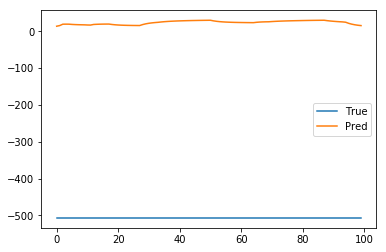

In [6]:
E1, E2 = RandEnergy(DEGREE, STATE_SIZE), RandEnergy(DEGREE, STATE_SIZE)
y = kl_divergence(E1, E2, n_samples=SAMPLES)
y_pred = np.array(list(esn.predict(ihstack(zip(monte_carlo(E1, n_samples=SAMPLES),
                                               monte_carlo(E1, n_samples=SAMPLES))),
                                   reset=True))).flatten()


plt.plot(y*np.ones(y_pred.shape))
plt.plot(y_pred)
plt.legend(['True', 'Pred'])
plt.show()